In [1]:
!pip install wordcloud -q
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 77.4 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [ ]:
import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from wordcloud import WordCloud
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap


# 1. Cleaning data and preprocessing

In [67]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

With this code, we will do:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.
5. **Filter rare words**

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [68]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

# We include additional stopwords that are specific to our corpus
custom_stops = ["candidat", "suppléant", "circonscription", "cest"]
for word in custom_stops:
    nlp.vocab[word].is_stop = True

In [69]:
############# functions to clean data ############

def preprocess_text(text, use_lemma=True):
    """Full preprocessing: OCR cleaning + tokenization + stopwords removal + lemmatization."""
    
    # --- OCR cleaning ---
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    
    # --- Lowercase + spaCy processing ---
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha and len(token) > 2:
            tokens.append(token.lemma_ if use_lemma else token.text)
    
    return " ".join(tokens)


def filter_rare_words(corpus, min_docs=5):
    """
    Filter out words appearing in fewer than min_docs documents.
    
    Parameters:
        corpus : List of preprocessed text strings.
        min_docs : Minimum number of documents a word must appear in to be kept.
            
    Returns:
        filtered_corpus : Corpus with rare words removed.
    """
    # Compute document frequency
    doc_freq = Counter()
    for text in corpus:
        for word in set(text.split()):
            doc_freq[word] += 1

    # Keep words appearing in at least min_docs documents
    vocab = {word for word, freq in doc_freq.items() if freq >= min_docs}

    # Filter each document
    filtered_corpus = [" ".join([word for word in text.split() if word in vocab])
                       for text in corpus]
    
    return filtered_corpus

# Execution
print("Starting text cleaning with spaCy (this may take 1–2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)
df_final["clean_text_filtered"] = filter_rare_words(df_final["clean_text"], min_docs=5)
print("Text cleaning completed")




Starting text cleaning with spaCy (this may take 1–2 minutes)...
Text cleaning completed


## 1.2 Wordclouds for each category

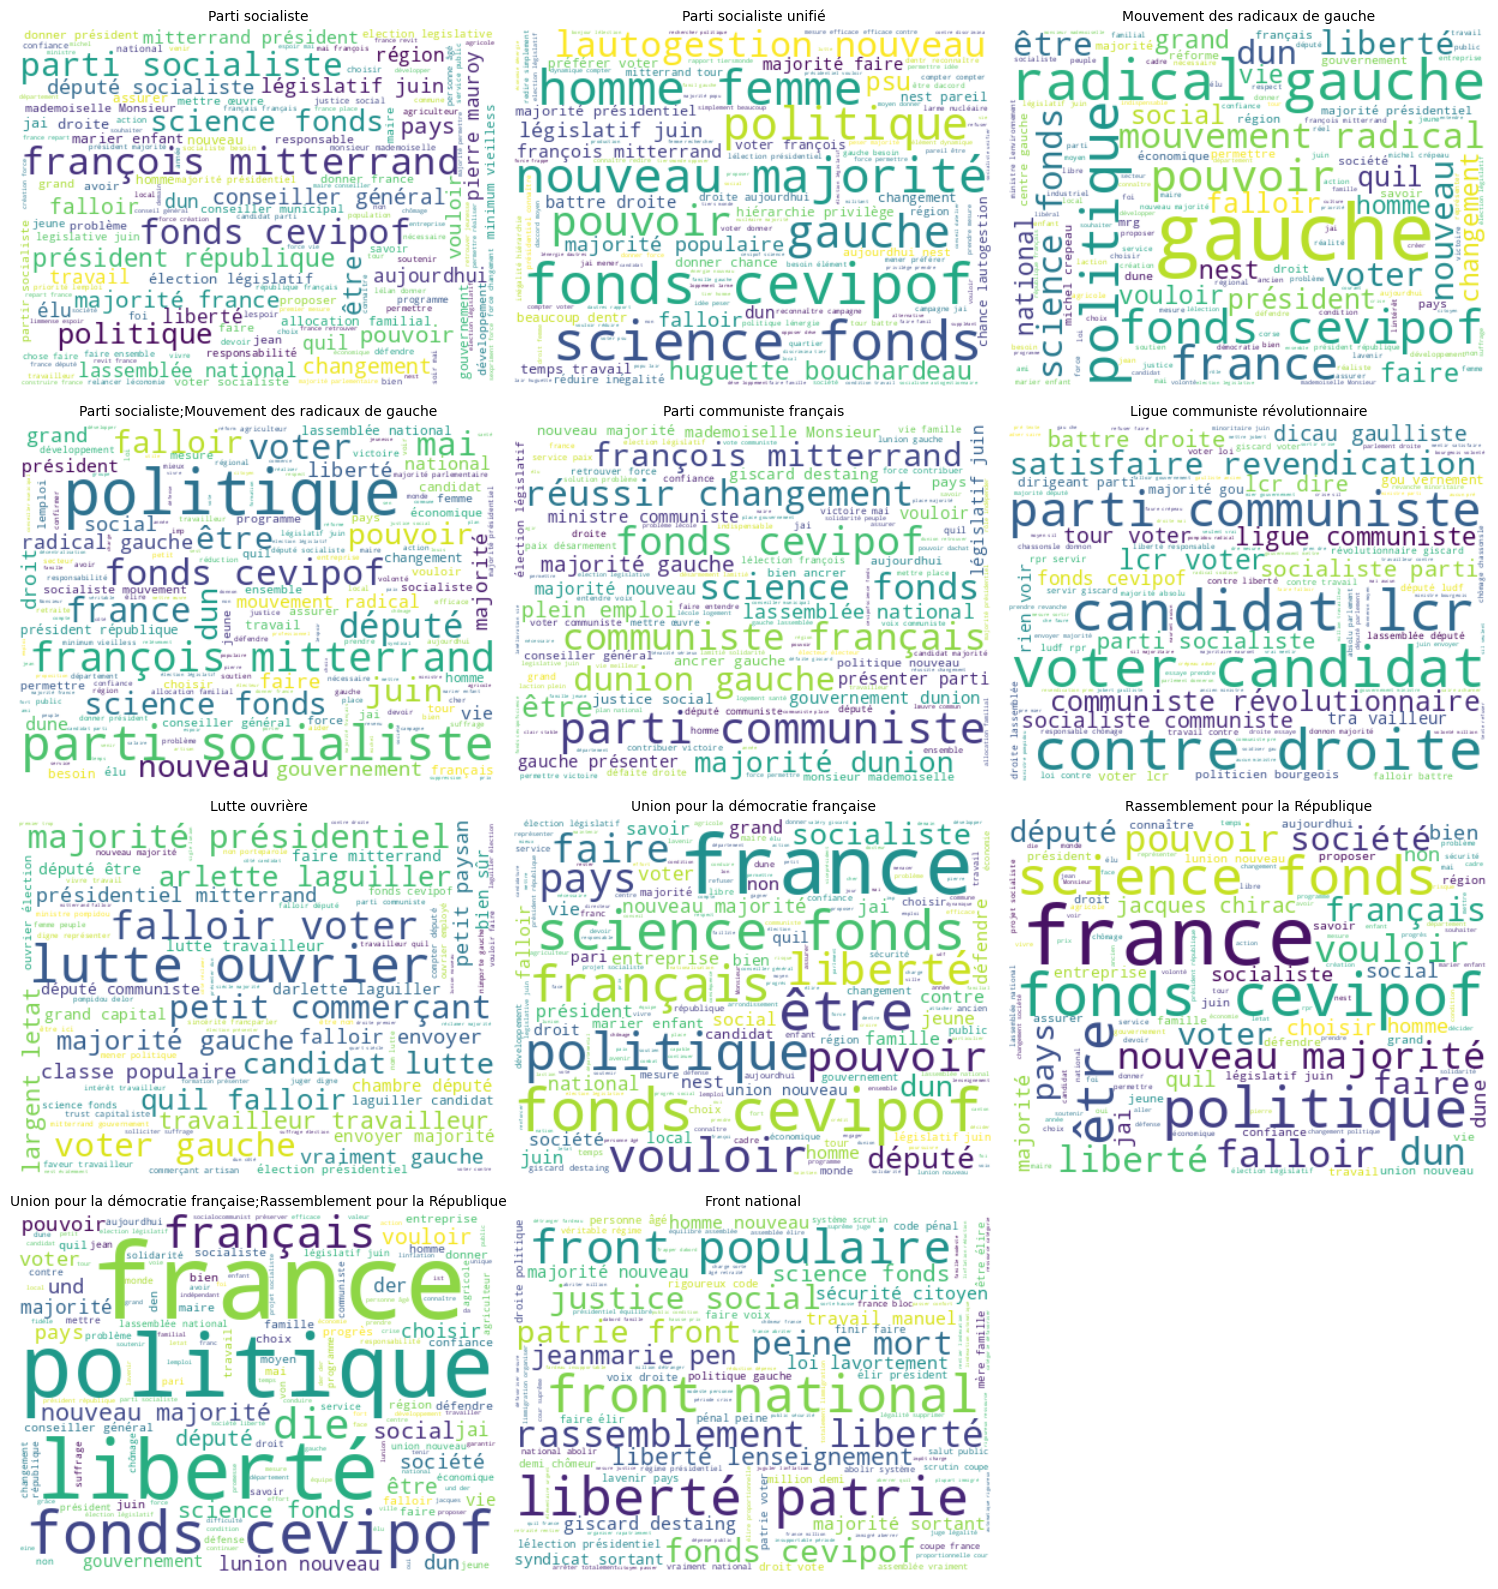

In [23]:

# List of categories in a specific order
categories = [
    "Parti socialiste", "Parti socialiste unifié",
    "Mouvement des radicaux de gauche", "Parti socialiste;Mouvement des radicaux de gauche",
    "Parti communiste français", "Ligue communiste révolutionnaire", "Lutte ouvrière",
    "Union pour la démocratie française", "Rassemblement pour la République",
    "Union pour la démocratie française;Rassemblement pour la République", "Front national"
]

# Number of columns for display and automatically computation of the number of rows
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols  


# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  

# Loop over categories and generate WordClouds
for i, cat in enumerate(categories):
    # Merge all preprocessed texts for the current category
    text_cat = " ".join(df_final[df_final['titulaire-soutien'] == cat]['clean_text_filtered'].astype(str))
    
    if text_cat.strip():  
        # Generate Wordcloud
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis'
        ).generate(text_cat)
        
        # Display the WordCloud in the subplot
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(cat, fontsize=10)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{cat} (no data)", fontsize=10)


# Remove unused axes if the number of categories is not a multiple of n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# 2. Regression logistic's implementation (first test without fusioning or deleting categories)

We first define a function to implement the logistic regression as we will implemente the model two times.

In [75]:
# To apply this functio, we need to clean data (section 1.1) before

def logistic_regression_nlp(df, text_col="vlean_text_filtered", label_col="titulaire-soutien", min_docs=5, cv_folds=5, random_state=42):
    """
    Performs logistic regression on NLP text data with TF-IDF features using Stratified CV.

    Parameters:
        df : DataFrame containing text and labels
        min_docs : Minimum number of documents a word must appear in
        cv_folds : Number of folds for StratifiedKFold
        random_state : Random state for reproducibility

    Returns:
        best_model : trained Pipeline with the best hyperparameters and confusion matrice
    """

    X = df["filtered_text"].astype(str)
    y = df[label_col].astype(str)

    # Pipeline
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("lr", LogisticRegression(max_iter=1000))
    ])

    # Hyperparameter grid
    param_grid = {
        'tfidf__max_features': [1000, 3000, 5000],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'lr__C': [0.1, 1.0, 10.0]
    }

    # GridSearch 
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X, y)

    best_model = grid.best_estimator_
    print(f"✅ Best hyperparameters: {grid.best_params_}, F1 (CV): {grid.best_score_:.4f}")

    # Cross-val predictions pour classification report et confusion matrix
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    print("\n--- CLASSIFICATION REPORT (CV) ---")
    print(classification_report(y, y_pred))

    fig, ax = plt.subplots(figsize=(15,10))
    ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    plt.title("Confusion Matrix (CV)")
    plt.tight_layout()
    plt.show()

    return best_model


Fitting 5 folds for each of 18 candidates, totalling 90 fits


✅ Best hyperparameters: {'lr__C': 10.0, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.8804

--- CLASSIFICATION REPORT (CV) ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      0.98      0.99        44
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                                                     Lutte ouvrière       1.00      0.99      1.00       159
                                   Mouvement des radicaux de gauche       1.00      0.85      0.92        46
                                          Parti communiste français       1.00      1.00      1.00       463
                                                   Parti socialiste       0.88      1.00      0.93       407
                                            Parti socialiste unifié       1.00      

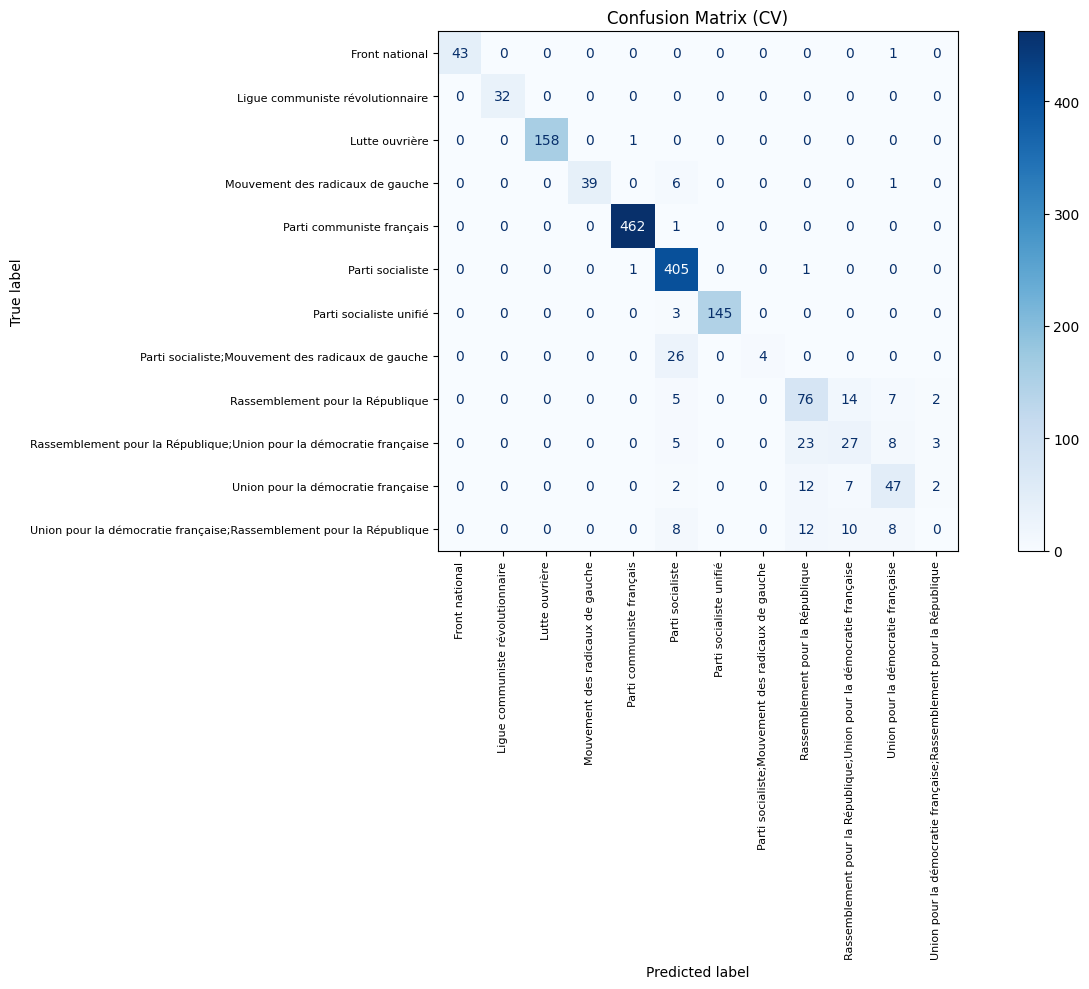

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [76]:
# Implementation of the logistic regression
logistic_regression_nlp(df_final, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

# 3. Logistic regression (after deleting the bi-support categories)

## 3.1 Model implementation

Fitting 5 folds for each of 18 candidates, totalling 90 fits


✅ Best hyperparameters: {'lr__C': 10.0, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.9649

--- CLASSIFICATION REPORT (CV) ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.98      0.99        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      0.99      1.00       159
  Mouvement des radicaux de gauche       1.00      0.89      0.94        46
         Parti communiste français       1.00      1.00      1.00       463
                  Parti socialiste       0.95      1.00      0.97       407
           Parti socialiste unifié       1.00      0.98      0.99       148
  Rassemblement pour la République       0.83      0.88      0.85       104
Union pour la démocratie française       0.85      0.67      0.75        70

                          accuracy                           0.97      1473
          

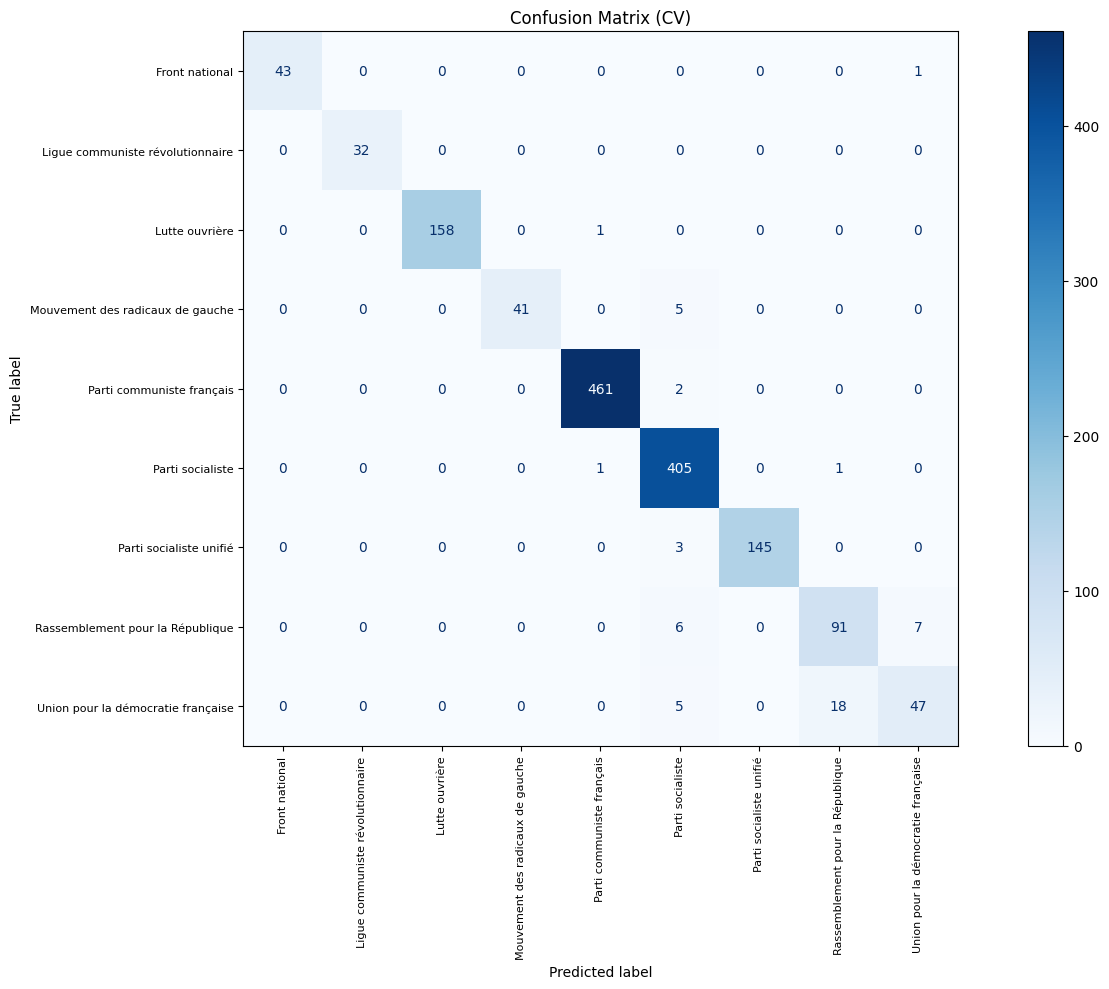

In [ ]:
# Deleting the bi-support categories
categories_a_supprimer = ['Parti socialiste;Mouvement des radicaux de gauche', 'Rassemblement pour la République;Union pour la démocratie française',  'Union pour la démocratie française;Rassemblement pour la République']
df_final_sans_cat_mixte = df_final[~df_final['titulaire-soutien'].isin(categories_a_supprimer)]

# Implementation of the logistic regression
best_model =logistic_regression_nlp(df_final_sans_cat_mixte, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

## 3.2 Coefficients' interpretation

In [101]:
# This block builds formatted tables of the most discriminant words 
# (largest absolute logistic regression coefficients) for each party 
# and displays them in grouped, color-coded layouts.

def build_party_table_abs(cat, top_n=10):
    """
    Build a table of the top |coef| features for a given party.

    Input: party/class name.

    Output: table with top_n features and their coefficients.
    """
    df_class = coef_df[coef_df['class'] == cat].copy()
    
    # Rank features by absolute coefficient magnitude
    df_class["abs_coef"] = df_class["coef"].abs()
    top_abs = df_class.sort_values("abs_coef", ascending=False).head(top_n)
    
    table = top_abs[["feature", "coef"]].reset_index(drop=True)
    table.columns = [f"{cat} - mot", f"{cat} - coef"]
    
    return table


def color_coef(val):
    """
    Assign color styling based on coefficient sign.

    Input: logistic regression coefficient.

    Output: CSS style (blue for positive, red for negative).
    """
    if val > 0:
        return "color: #1f77b4; font-weight: bold;"  # blue
    elif val < 0:
        return "color: #d62728; font-weight: bold;"  # red
    else:
        return ""


def display_three_parties_abs(categories, n_cols=3, top_n=10):
    """
    Display styled tables of top |coef| features for parties,
    grouped by rows of n_cols parties.

    Input: 
        categories: list of party names.
        n_cols: number of parties displayed per row.

    Output: None
    """
    for i in range(0, len(categories), n_cols):
        block = categories[i:i+n_cols]
        
        tables = [build_party_table_abs(cat, top_n=top_n) for cat in block]
        combined = pd.concat(tables, axis=1)
        
        coef_cols = [col for col in combined.columns if "coef" in col]
        
        styled = combined.style.applymap(color_coef, subset=coef_cols)
        display(styled)


In [102]:
display_three_parties_abs(categories)


/tmp/ipykernel_108795/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti socialiste - mot,Parti socialiste - coef,Parti socialiste unifié - mot,Parti socialiste unifié - coef,Mouvement des radicaux de gauche - mot,Mouvement des radicaux de gauche - coef
0,socialiste,5.841756,psu,3.371610,radical,5.331992
1,parti socialiste,4.768368,nucléaire,3.245173,radical gauche,5.244233
2,communiste,-3.994083,autogestionnaire,2.583148,mouvement radical,4.008238
3,gauche,-3.600671,lautogestion,2.225654,gauche,2.552985
4,françois mitterrand,3.595356,quartier,1.953085,mrg,2.538281
5,françois,3.162900,populaire,1.903092,michel,2.233275
6,mitterrand,3.158259,bouchardeau,1.728178,mouvement,2.020400
7,président,3.057532,alternative,1.638535,michel crepeau,1.851317
8,union,-2.019836,huguette,1.600913,crepeau,1.851317
9,pierre,2.019114,tiersmonde,1.600900,centre gauche,1.409365


/tmp/ipykernel_108795/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Parti communiste français - mot,Parti communiste français - coef,Ligue communiste révolutionnaire - mot,Ligue communiste révolutionnaire - coef,Lutte ouvrière - mot,Lutte ouvrière - coef
0,communiste,6.746958,lcr,1.575801,travailleur,2.091360
1,gauche,4.124068,candidat lcr,1.037601,lutte ouvrier,1.656909
2,communiste français,3.037930,lunité,1.033457,ouvrier,1.578326
3,dunion,2.973782,patron,0.925422,lutte,1.494446
4,socialiste,-2.796609,contre,0.781633,gauche,1.337873
5,réussir,2.729859,satisfaire revendication,0.721272,laguiller,1.235686
6,parti communiste,2.574004,droite,0.714951,mitterrand,1.083050
7,changement,2.533150,voie,0.703114,trop,0.993598
8,réussir changement,2.043043,revendication,0.703031,intérêt,0.956258
9,contribuer,1.944321,voter candidat,0.683590,quil,0.939287


/tmp/ipykernel_108795/3523363331.py:60: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols)


,Union pour la démocratie française - mot,Union pour la démocratie française - coef,Rassemblement pour la République - mot,Rassemblement pour la République - coef,Front national - mot,Front national - coef
0,union,2.777954,jacques chirac,4.222813,patrie,2.637541
1,gauche,-2.552877,jacques,2.834358,front,2.509447
2,excès,2.483430,société,2.822643,front national,2.154617
3,démocrate,2.143254,chirac,2.442532,liberté patrie,1.745064
4,union nouveau,2.135509,gauche,-2.378214,pen,1.506977
5,udf,2.133682,nouveau majorité,2.000748,rassemblement,1.458158
6,libéral,1.951285,rassemblement république,1.965735,national,1.392690
7,france,1.827522,union nouveau,1.960398,jeanmarie pen,1.363621
8,changement,-1.763163,liberté,1.917649,rassemblement liberté,1.341151
9,progrès social,1.740610,oui,1.840633,jeanmarie,1.222423


## 3.3 Indice de dissmiliraté entre les partis

The coefficients estimated by the logistic regression allow us to construct a dissimilarity index between parties. This index enables us to identify parties that are semantically closest to each other or, conversely, the most distant.

In [116]:
###############Build a coefficient matrix for all parties () Rows = parties, Columns = features) ##########################""""""

coef_matrix = []  # list to store coefficients for each party

for cat in categories:
    # Select all coefficients for this party
    df_cat = coef_df[coef_df['class'] == cat].copy()
    
    # Sort features alphabetically to align columns across parties
    df_cat = df_cat.sort_values('feature')
    
    # Append the coefficients as a row
    coef_matrix.append(df_cat['coef'].values)

# Convert list of rows to numpy array
coef_matrix = np.array(coef_matrix)


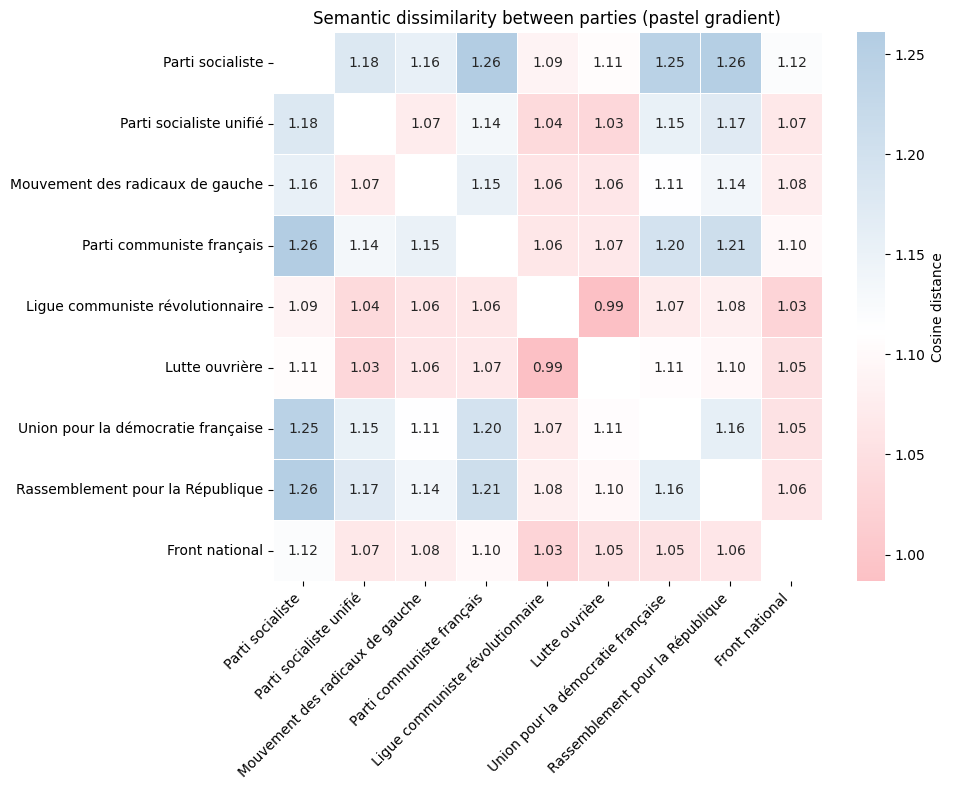

In [118]:
############ Plot a heatmap of semantic dissimilarity between parties using a smooth pastel gradient #####

dist_plot = dist_df_cos.copy()

# Set diagonal to NaN so it appears white in the heatmap
np.fill_diagonal(dist_plot.values, np.nan)

plt.figure(figsize=(10, 8))

# Define a soft pastel gradient: pale pink -> white -> light blue
colors = ["#fbb4b9", "white", "#b3cde3"]
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors)

# Plot heatmap with annotations and pastel colors
sns.heatmap(
    dist_plot,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=dist_plot.mean().mean(),  # center gradient on the mean value
    linewidths=0.5,
    cbar_kws={'label': 'Cosine distance'},
    square=True
)

# Adjust labels and layout
plt.title("Semantic dissimilarity between parties (pastel gradient)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

